## About this code

This script describes a pipeline for the domain relevance classification algorithm.<br>
Input: a tweet or batch of tweets<br>
Process: apply feature engineering, modeling and classification (0,1 - relevant or 2 - not relevant)<br>
Output: a classification per input. Relevance=0 means the tweet ragards Israel generally, '1' suggest political/religious context and '2' means irrelevant tweet (noise).
1. Using the Pipeline.py for pre-process, feature engineering (NLP, entities, user features) and feature selection
2. Classification - one problem of two classes ('2' and 'not 2'). 
3. Evaluation

RESULTS:<br>
**0 - RELEVANT, 1 - NOT RELEVANT**

# Table of Content

- <a href="#Run-configurations">Run configurations</a>
- <a href="#Data-import">Data import</a>
- <a href="#Run-pipeline">Run pipeline</a>
- <a href="#KDE-plots">KDE plots</a>
- <a href="#Phase-1--Relevance-to-domain">Phase 1- Relevance to domain</a>
    - <a href="#First-evaluation-('2'-vs.-all)">First evaluation ('2' vs. all)</a>
- <a href="#Phase-2---Relevance-type">Phase 2 - Relevance type</a>
    - <a href="#Remove-irrelevant-data">Remove irrelevant data</a>
    - <a href="#Adding-features">Adding features</a>
    - <a href="#Evaluation">Evaluation</a>

## Run configurations

In [1]:
config = {
            # Mode
            'learning': True,           # True at the train phase, False when operational - predict new data using existing model 
            
            # Data
            'filter_taggers': False,    # If to filter labeled data by the tagger - Yogev, Ofir and Itay
            'target': 'relevance',        # The target of the algorithm
            'load_df_from_pickle': True,  # If to load a ready data frame or to do the entire pipeline from the beginning 
            
            # Pre-process
            'slang': True,              # If to handle slang words, also for Feature engineering
            'spell_correction': False,  # If to use spell correction in the pre-proccess phase 
            'col': 'text',              # Column to apply pre-proccess on - used by the proccess_tweet function in tweet_pre_proccess.py
            
            # Feature engineering
            'nlp_features': True,
            'dominant_keywords': True,
            'dominant_keywords_metric': 'entropy',
            'user_features': False,
            'time_and_event': False,    # Time and event features
            'network_features': False,
                'load_network_data': False,
            'nlp_raw': True,
            'sentiment': False,         #sentiment analysis feature. if false, dominant words feature won't be created also
            'emotion': False,           #emotion feature. will be false for the relevance classification
            'word_type': False,         #word class dict feature. will be false for the relevance classification 
            'hashtags_and_mentions': True,
            'num_dominant_words': 100,  # Number of dominant words to use in the NLP features (dominant_keywords function - parameter k)
            'min_word_appearances': 4,# Min number of appearnces (#tweets) for dominant word to be considered dominant
            'min_couple_appearances': 4,# For couple of dominant words -
                                        # how many time the combination need to appear in the data in order to become a feature        
            'url_features': False,
            'Tweets_media_and_content': True,
            'country_support': False,
            'entities_features': True,
    
            # Feature selection
            'feature_selection': True,
            'remove_features_zero_variance': True,        
            'remove_correlated_features': False,
            'remove_low_correlated_features': False,
            'feature_importance': True,
            'corr_per_thresh': 0.0,    # Percentile threshold of Min correlation between a feature and the target variable (abs) 
            'importance_per_thresh': 25,# Percentile threshold of Min importance of a feature
            'PCA': False,               # If the use PCA to reduce dimensiality
            'PCA_var': 0.995,           # % of commulative explained variance required from PCA (affect #of PC)

            # Model
            'model': 'ALL',
            'load_model_pickle': False, # If to import existing models from pickle
            'regression': False,        # If to run regression model also
            'validation': False,        # If to use train split to train and validation
            'class_threshold': 0.0,     # Probability threshold in order to classify a tweet as negative/neurtal/positive
            'bench_from_pickle': True
    }

Imports

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
import seaborn as sns
import os
import glob
import csv
import time
import matplotlib
import pickle
from tqdm import tqdm, trange, tqdm_notebook, tqdm_pandas
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics

In [3]:
# Avoid trimming text in jupyter preview
pd.set_option('display.max_colwidth', -1)

In [4]:
# Set start time of the script
start = time.time()

In [5]:
#plt.style.use('ggplot')
%matplotlib inline

In [6]:
np.random.seed = 1234
tqdm.pandas(tqdm_notebook())

#### Import thesis modules

In [7]:
os.chdir('../pipeline')
import domain_entities
import nlp_url_features
import tweet_pre_proccess
import nlp_features
import eda
import ml_model
import slang
import pipeline
os.chdir('../{} algo'.format(config['target']))

## Data import

In [8]:
labeled_data = pd.read_csv("../../data/classifiers/labeled_data.csv", header=0, encoding='utf-8')

In [9]:
# Filter bad taggers
labeled_data = labeled_data[labeled_data.Tagger.isin(['ofir','yogev','Itay'])] if config['filter_taggers'] else labeled_data

In [10]:
labeled_data.dtypes

Unnamed: 0     int64  
relevance      int64  
support        object 
Tagger         object 
created_at     int64  
emotion        object 
screen_name    object 
text           object 
id             float64
dtype: object

In [11]:
data_tweets = labeled_data[['id','text','relevance','support','emotion','screen_name','created_at']]
data_tweets.reset_index()
# Remove tweets with no target label
data_tweets = data_tweets.dropna(subset=[config['target']])
if config['target']=='support':
    # Remove irrelevant tweets ('Relevance' = 2)
    data_tweets = data_tweets[data_tweets['relevance']!=2]
else:
    del data_tweets['support']
    data_tweets['relevance'] = data_tweets['relevance'].apply(lambda x: int(x))

In [12]:
# Load csv
test_set = pd.read_csv('../../data/classifiers/test.csv', header=0, encoding='utf-8')
test_set = test_set[['id','text','relevance','support','emotion','screen_name','created_at']]

### Data balance

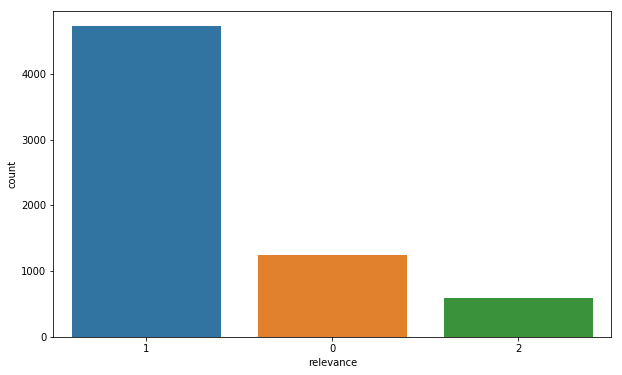

In [13]:
plt.figure(num=None, figsize=(10, 6), facecolor='w', edgecolor='k')
h = sns.countplot(x=config['target'], data=data_tweets, order = data_tweets[config['target']].value_counts().index)

In [14]:
data_tweets.head(n=1)

,id,text,relevance,emotion,screen_name,created_at
0,4.030000e+17,"""Join Students for Justice in Palestine (SJP UMN) this Wednesday at 4:30 pm with Josh Ruebner. His book """"Shattered... http://fb.me/2FbldzgdgÂ¬â€ """,0,NaN,ampminnesota,1384803626


## Run pipeline

#### Run pipeling

In [15]:
df = pipeline.pipeline(data_tweets, config) if not config['load_df_from_pickle'] else pd.read_pickle('../../data/classifiers/relevance_pipeline_train.pkl')

Null values check

In [16]:
for col in data_tweets.columns:
    counter = data_tweets[col].isnull().sum().sum()
    print(col) if counter > 0 else None

emotion


In [17]:
if not config['load_df_from_pickle']:
    df.to_pickle('../../data/classifiers/relevance_pipeline_train.pkl')

Export final feature list (after feature selection) to picle.<br>
These features will be applied to new data at the production phase.

Show df

In [18]:
pd.set_option('display.max_columns', None)
df._get_numeric_data().describe()

,created_at,created_at,hash_#apartheid,hash_#bds,hash_#cnn,hash_#earthquake,hash_#economy,hash_#flotilla,hash_#gaza,hash_#gazaunderattack,hash_#hamas,hash_#health,hash_#icc4israel,hash_#iran,hash_#islam,hash_#israel,hash_#istandwithisrael,hash_#jerusalem,hash_#land,hash_#lovely,hash_#nbc,hash_#netanyahu,hash_#news,hash_#nufc,hash_#obama,hash_#palestine,hash_#palestinian,hash_#peace,hash_#politics,hash_#sjp,hash_#standwithisrael,hash_#syria,hash_#un,hash_#us,num_capital_letters,num_capital_words,num_hashtags,num_mentions,num_negation_words,num_tokens,num_words_len_1,relevance,relevance,text_length_vs_tokens_ratio,total_important_hashtags,tweet_length,word_17,word_34,word_ahituv,word_american,word_ann,word_apartheid,word_attack,word_bds,word_bicycl,word_bomb,word_breed,word_campus,word_car,word_cardboard,word_citi,word_compani,word_conflict,word_crime,word_david,word_de,word_earthquak,word_eau,word_edt,word_evan,word_fan,word_fire,word_flotilla,word_for,word_ft,word_gaza,word_god,word_gurion,word_hamas,word_happi,word_holland,word_im,word_india,word_innov,word_israel,word_israeli,word_istandwithisrael,word_japan,word_jew,word_justice,word_justin,word_kill,word_lord,word_love,word_moffic,word_new,word_nufc,word_obama,word_ounc,word_oz,word_palestine,word_palestinian,word_peace,word_philippines,word_protest,word_rabbi,word_rocket,word_sale,word_say,word_sex,word_silki,word_sjp,word_spain,word_spray,word_standwithisrael,word_startup,word_state,word_strike,word_student,word_support,word_terror,word_terrorist,word_toilett,word_tour,word_un,word_violenc,word_war,word_west,word_women,word_â€šã„â¶,num_slang_words,has_pro_org,has_anti_org,has_israeli_politician,has_us_politician,has_terror_orgs,has_hostile_countries,has_news_company,hostile_entities,positive_entities,num_domain_keywords,has_image,has_video_ref,has_link,has_RT,subjectivity,created_at,created_at,relevance,relevance
count,6.563000e+03,6.563000e+03,6563.000000,6563.000000,6563.00000,6563.000000,6563.000000,6563.000000,6563.000000,6563.000000,6563.000000,6563.000000,6563.000000,6563.000000,6563.000000,6563.000000,6563.000000,6563.000000,6563.000000,6563.000000,6563.000000,6563.00000,6563.000000,6563.000000,6563.000000,6563.000000,6563.000000,6563.000000,6563.000000,6563.000000,6563.000000,6563.000000,6563.000000,6563.000000,6563.000000,6563.000000,6563.000000,6563.000000,6563.000000,6563.000000,6563.000000,6563.000000,6563.000000,6563.000000,6563.000000,6563.000000,6563.00000,6563.000000,6563.000000,6563.000000,6563.000000,6563.000000,6563.000000,6563.000000,6563.000000,6563.000000,6563.000000,6563.000000,6563.000000,6563.000000,6563.000000,6563.000000,6563.000000,6563.000000,6563.000000,6563.000000,6563.000000,6563.000000,6563.000000,6563.000000,6563.000000,6563.000000,6563.000000,6563.000000,6563.000000,6563.000000,6563.000000,6563.000000,6563.000000,6563.00000,6563.000000,6563.000000,6563.000000,6563.000000,6563.000000,6563.000000,6563.000000,6563.000000,6563.000000,6563.000000,6563.000000,6563.000000,6563.000000,6563.000000,6563.000000,6563.000000,6563.000000,6563.000000,6563.000000,6563.000000,6563.000000,6563.000000,6563.000000,6563.000000,6563.000000,6563.000000,6563.000000,6563.000000,6563.000000,6563.000000,6563.000000,6563.000000,6563.000000,6563.000000,6563.000000,6563.000000,6563.000000,6563.000000,6563.000000,6563.000000,6563.000000,6563.000000,6563.000000,6563.000000,6563.000000,6563.000000,6563.000000,6563.000000,6563.000000,6563.000000,6563.000000,6563.000000,6563.000000,6563.000000,6563.000000,6563.000000,6563.000000,6563.000000,6563.000000,6563.000000,6563.000000,6563.000000,6563.000000,6563.000000,6563.000000,6563.000000,6.563000e+03,6.563000e+03,6563.000000,6563.000000
mean,1.382083e+09,1.382083e+09,0.012647,0.051958,0.00320,0.004419,0.001219,0.019351,0.086089,0.010209,0.006552,0.003962,0.001828,0.005638,0.001981,0.147494,0.004876,0.009295,0.000762,0.010818,0.001371,0.00320,0.012494,0.003047,0.003352,0.095536,0.007923,0.001524,0.005181,0.095536,0.002743,0.

### KDE plots

In [19]:
# labels = {'support': {'names': ['Anti-Israel', 'Neutral', 'Pro-Israel'], 'values': [-1,0,1]},
#           'relevance': {'names': ['General', 'Political', 'Ignore'], 'values': [0,1,2]}}

# features = [col for col in df.columns.tolist() if col not in ([config['target'], 'text', 'tokenized_text'])]
# eda.kde_plots(df, features, config['target'], labels[config['target']]['names'])

## Phase 1- Relevance to domain

In [20]:
# Updated features list
features = [col for col in df.columns.tolist() if col not in ([config['target'], 'text', 'tokenized_text', 'id', 'created_at', 'screen_name'])]

In [21]:
with open('{}_features_list.pickle'.format(config['target']), 'wb') as handle:
    pickle.dump(features, handle, protocol=pickle.HIGHEST_PROTOCOL)

### Train-test split

#### Change configurations for test set build 

In [22]:
for attr in ['learning', 'feature_selection', 'remove_features_zero_variance', 'remove_correlated_features', 'remove_low_correlated_features', 'feature_importance']:
    config[attr] = False
config['min_word_appearances'], config['min_couple_appearances']= 0,0

In [23]:
# Remove tweets with no target label
test_set = test_set.dropna(subset=[config['target']])
if config['target']=='support':
    # Remove irrelevant tweets ('Relevance' = 2)
    test_set = test_set[test_set['relevance']!=2]
else:
    del test_set['support']
    test_set['relevance'] = test_set['relevance'].apply(lambda x: int(x))

# Run pipeline on test set
test_set = pipeline.pipeline(test_set, config) if not config['load_df_from_pickle'] else pd.read_pickle('../../data/classifiers/relevance_pipeline_test.pkl')

In [24]:
if not config['load_df_from_pickle']:
    test_set.to_pickle('../../data/classifiers/relevance_pipeline_test.pkl')

In [25]:
df.reset_index(inplace=True)
test_set.reset_index(inplace=True)

In [26]:
df = df.loc[:,~df.columns.duplicated()]

In [27]:
x_train, y_train, x_test, y_test = df[features], df[config['target']], test_set[features], test_set[config['target']]

In [28]:
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression

### Relevnce to domain classification

In [29]:
# All models configurations
model_objects = {'Random Forest': RandomForestClassifier,
                 'Naive Bayes': GaussianNB,
                 'Logistic Regression': LogisticRegression,
                 'SVM':SVC
                }

model_stats = {
                 'Random Forest': {},
                 'SVM':{},
                 'Naive Bayes': {},
                 'Logistic Regression': {}
                }

tuned_parameters_set = {'Random Forest': {'min_samples_split':[4, 8, 10, 15], 'max_depth':[5,15,20],'criterion':['gini', 'entropy'],
                   'n_estimators':[100,250,500], 'random_state':[1], 'n_jobs':[-1]
                                         },
                        'SVM': {'C':[0.1], 'kernel':['linear'], 'random_state':[1],
                                 'gamma':[0.1, 1, 10], 'cache_size': [6000], 'probability': [True]
                                },
                        'Naive Bayes': {'priors': [x / sum(list(df.relevance.value_counts())) for x in list(df.relevance.value_counts())]},
                        'Logistic Regression': {'penalty': ["l2"], #What is our loss function? l2 stands for quad_distances, l1 stands for abs distance.
                             'dual': [False], #How to define our objective function, as the primal or the dual?
                             'tol': [0.0001], #Stopping critiria
                             'C': [0.1,1,10], #Inverse regularization parameter, large C means less regularization.
                             'fit_intercept': [True], #As it sounds, do we want to learn an intercept?
                             'intercept_scaling': [1], #What is the initialization of the intercept parameter
                             'class_weight': [None], #How to treat different classes?
                             'random_state': [1], #The seed
                             'solver': ["liblinear"], #What is the algorithm used to solve the problem?
                             'max_iter': [100], #For some optimization algorithms, the algorithm solves it with iterations.
                             #'multi_class': ["ovr"], #How to treat multiclass problems, doesn't matter for our course.
                             'verbose': [2], 
                             'warm_start': [False], 
                             'n_jobs':[1]}
    }

normalizations = {'Random Forest': [False, False], # If to normalize, normalization type
                 'SVM':[True, 'Scaling'],
                 'Naive Bayes': [True, 'Scaling'],
                 'Logistic Regression': [True, 'Scaling']}

############################################################################
MODEL: Random Forest
Best parameters are: {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 20, 'min_samples_split': 8, 'n_estimators': 100, 'n_jobs': -1, 'random_state': 1}
Model AUC: 0.936


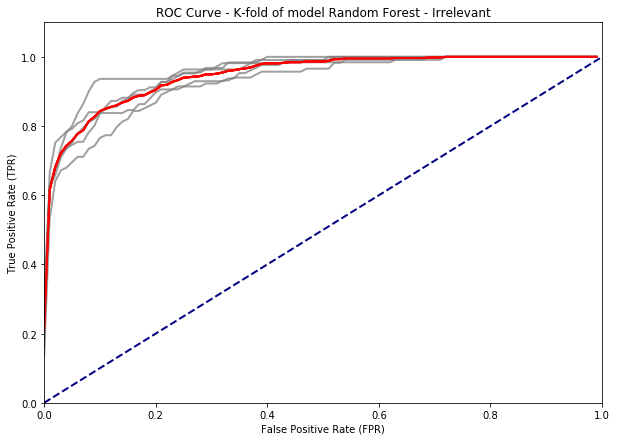

The average AUC over 5-folds is: 0.948
The average accuracy over 5-folds is: 94.91%
The MSE on the train set: 0.0380
The MSE on the test set: 0.0430


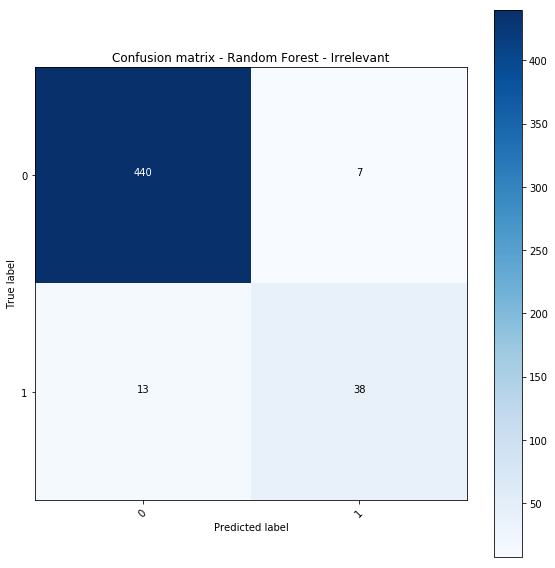

Accuracy on test: 0.96


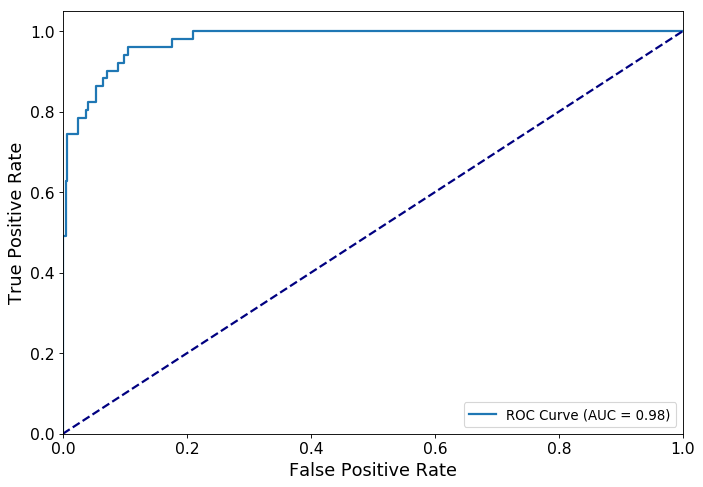

AUC achieved: 0.98
############################################################################
MODEL Random Forest SUMMARY
############################################################################
MODEL: Naive Bayes


D:\LEMA Shared Folder\Twitter Thesis\Code\thesis-classifiers\pipeline\ml_model.py:155: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by the scale function.
  df = preprocessing.scale(df, with_mean = center, with_std = std)  # Z scaling (minus average, and divide by the std)
D:\LEMA Shared Folder\Twitter Thesis\Code\thesis-classifiers\pipeline\ml_model.py:163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[col] = df[col]-columns_data[col]['avg'] if center else df[col]
D:\LEMA Shared Folder\Twitter Thesis\Code\thesis-classifiers\pipeline\ml_model.py:164: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

Classes priors: [0.9101, 0.0899]


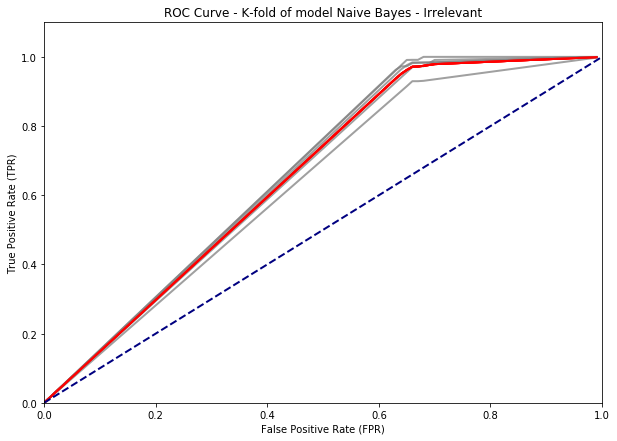

The average AUC over 5-folds is: 0.660
The average accuracy over 5-folds is: 39.59%
The MSE on the train set: 0.6038
The MSE on the test set: 0.5622


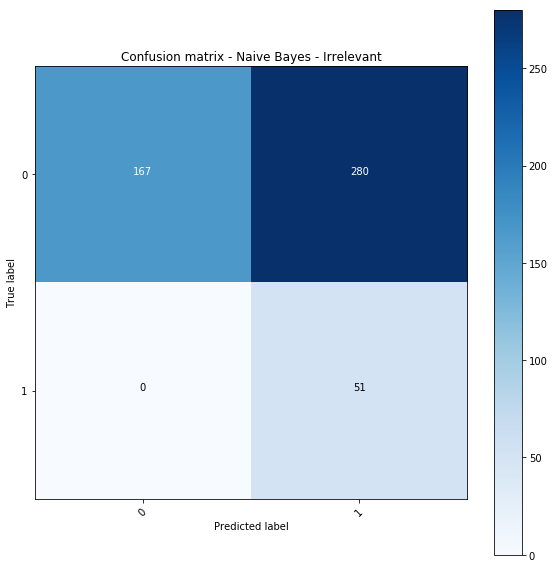

Accuracy on test: 0.44


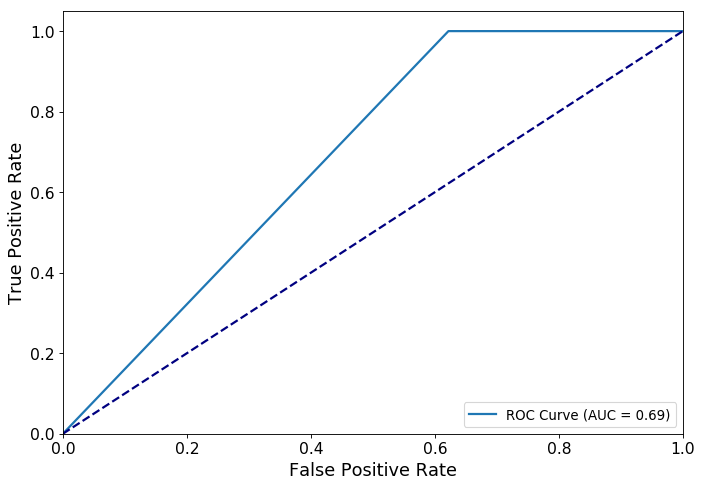

AUC achieved: 0.69
############################################################################
MODEL Naive Bayes SUMMARY
############################################################################
MODEL: Logistic Regression


D:\LEMA Shared Folder\Twitter Thesis\Code\thesis-classifiers\pipeline\ml_model.py:155: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by the scale function.
  df = preprocessing.scale(df, with_mean = center, with_std = std)  # Z scaling (minus average, and divide by the std)
D:\LEMA Shared Folder\Twitter Thesis\Code\thesis-classifiers\pipeline\ml_model.py:163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[col] = df[col]-columns_data[col]['avg'] if center else df[col]
D:\LEMA Shared Folder\Twitter Thesis\Code\thesis-classifiers\pipeline\ml_model.py:164: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]Best parameters are: {'C': 1, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'max_iter': 100, 'n_jobs': 1, 'penalty': 'l2', 'random_state': 1, 'solver': 'liblinear', 'tol': 0.0001, 'verbose': 2, 'warm_start': False}
Model AUC: 0.906
[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

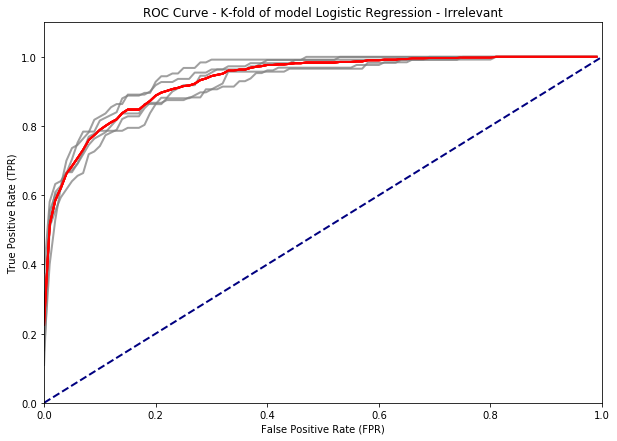

The average AUC over 5-folds is: 0.933
The average accuracy over 5-folds is: 94.71%
[LibLinear]The MSE on the train set: 0.0384
The MSE on the test set: 0.4118


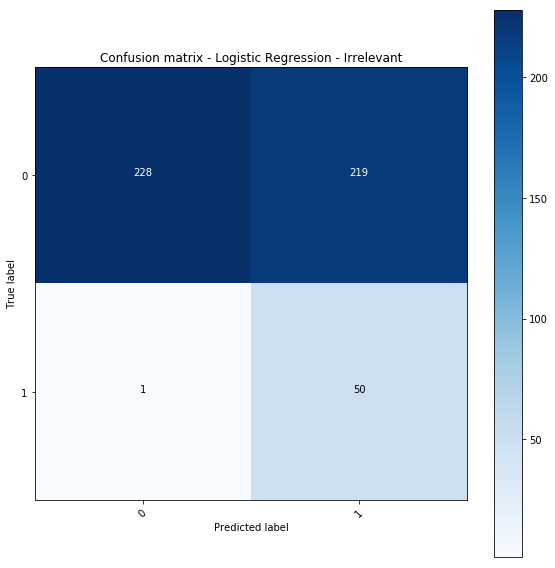

Accuracy on test: 0.56


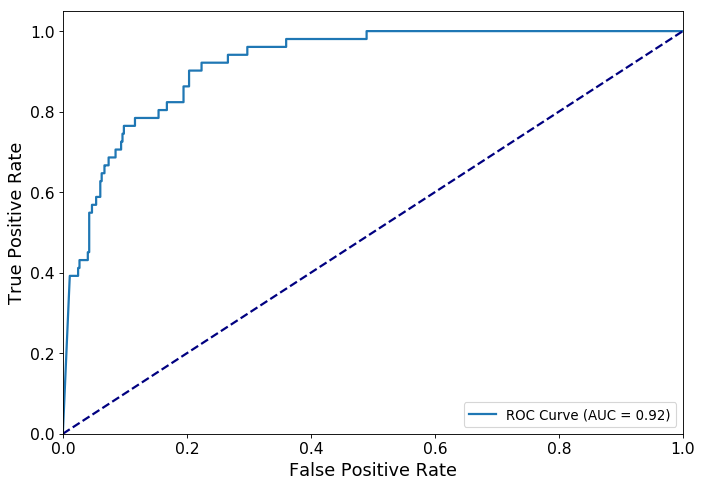

AUC achieved: 0.92
############################################################################
MODEL Logistic Regression SUMMARY
############################################################################
MODEL: SVM


D:\LEMA Shared Folder\Twitter Thesis\Code\thesis-classifiers\pipeline\ml_model.py:155: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by the scale function.
  df = preprocessing.scale(df, with_mean = center, with_std = std)  # Z scaling (minus average, and divide by the std)
D:\LEMA Shared Folder\Twitter Thesis\Code\thesis-classifiers\pipeline\ml_model.py:163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[col] = df[col]-columns_data[col]['avg'] if center else df[col]
D:\LEMA Shared Folder\Twitter Thesis\Code\thesis-classifiers\pipeline\ml_model.py:164: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

Best parameters are: {'C': 0.1, 'cache_size': 6000, 'gamma': 0.1, 'kernel': 'linear', 'probability': True, 'random_state': 1}
Model AUC: 0.900


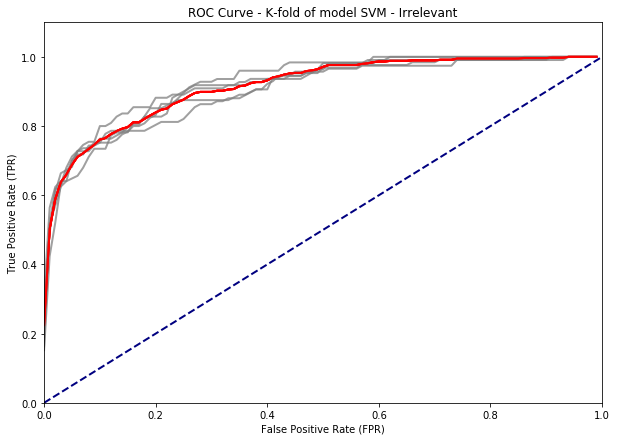

The average AUC over 5-folds is: 0.915
The average accuracy over 5-folds is: 94.61%
The MSE on the train set: 0.0400
The MSE on the test set: 0.4276


C:\Users\yogevmatalon\AppData\Local\conda\conda\envs\Twitter\lib\site-packages\scipy\interpolate\interpolate.py:2756: RuntimeWarning: divide by zero encountered in true_divide
  tmp = dot(tmp,np.diag(1.0/s))


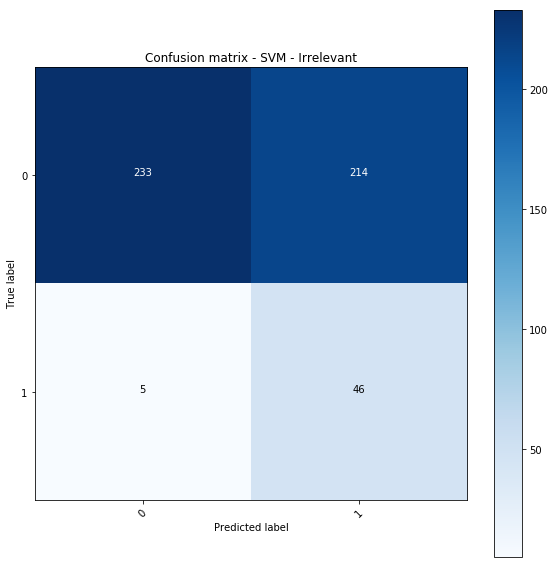

Accuracy on test: 0.56


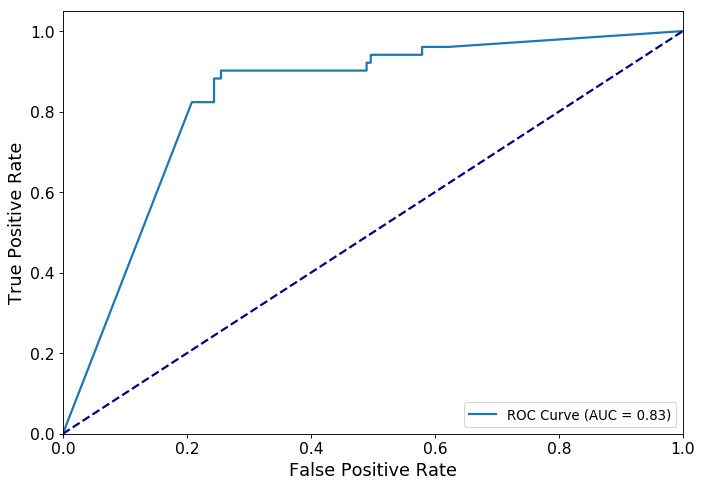

AUC achieved: 0.83
############################################################################
MODEL SVM SUMMARY


In [30]:
# Reset time
model_start = time.time()

if config['load_model_pickle']:
    with open('../../data/classifiers/relevance_model.pickle', 'rb') as handle:
        model = pickle.load(handle)
else:
    relevance_models = {}
    classes = {2: 'Irrelevant'}
    if config['model'] == 'ALL':
        # Iterate over all models
        for ml_model_name in model_objects:
            pipeline.print_seperator()
            print('MODEL:', ml_model_name)
            # Set the current model and the parmeters grid to be checked
            config['model'], tuned_parameters = ml_model_name, tuned_parameters_set[ml_model_name]
            
            # Normalize the data
            if normalizations[config['model']][0]: # If normalization is required
                cur_x_train, columns_data = ml_model.normalize(x_train, normalizations[config['model']][1])
                cur_x_test = ml_model.normalize(x_test, normalizations[config['model']][1], columns_data)
            else:
                cur_x_train, cur_x_test = x_train, x_test
                
            # Iterate over all models
            config['model'] = ml_model_name
            # Choose the model object
            model_obj = model_objects[config['model']]
            # Run model
            if ml_model_name=='Naive Bayes': # Choose relevant prior: [tuned_parameters[relevant_class],1-tuned_parameters[relevant_class]]
                relevance_models[2], model_stats[config['model']][2] = ml_model.run_ML_model(model_obj, '{} - {}'.format(config['model'], classes[2]), 2, cur_x_train, cur_x_test, y_train, y_test, [1-tuned_parameters['priors'][2],tuned_parameters['priors'][2]], 5, 'roc_auc', True, True)
            else:
                # (model_object, model name, relevant_class, x_train, x_test, y_train, y_test, tuned_parameters, num of k fold, target metric, check_on_test)
                relevance_models[2], model_stats[config['model']][2] = ml_model.run_ML_model(model_obj, '{} - {}'.format(config['model'], classes[2]), 2, cur_x_train, cur_x_test, y_train, y_test, tuned_parameters, 5, 'roc_auc', True, True)

            # Save model in a pickle file
            with open('../../data/classifiers/relevance_models_{}.pickle'.format(config['model']), 'wb') as handle:
                pickle.dump(relevance_models, handle, protocol=pickle.HIGHEST_PROTOCOL)
            
            # Evaluation
            pipeline.print_seperator()
            print('MODEL {} SUMMARY'.format(ml_model_name))
            #model_stats[ml_model_name]['summary'] = ml_model.evaluate_multi_class_algo(cur_x_train, y_train, cur_x_test, y_test, support_models, config)
    
    # Save models in a pickle file
    with open('../../data/classifiers/relevance_model.pickle', 'wb') as handle:
        pickle.dump(relevance_models, handle, protocol=pickle.HIGHEST_PROTOCOL)

<div class="alert alert-block alert-success">
Only one instance of true relevant tweet was classified as non-relevant.<br>
</div>

## Evaluation ('2' vs. all)
Prepare for evaluation

In [29]:
# Use models to predict the test
prob_train = {}
prob_test = {}
# prob_external_test = {}
prob_train['prediction'] = model.predict(x_train)
prob_test['prediction'] = model.predict(x_test)
# prob_external_test['prediction'] = model.predict(x_external_test)

# Build data frames for all test predictions, from the relevance model
predictions_train = pd.DataFrame.from_dict(prob_train, orient='columns')
predictions_test = pd.DataFrame.from_dict(prob_test, orient='columns')
# predictions_external_test = pd.DataFrame.from_dict(prob_validation, orient='columns')

predictions_train['true_value'] = y_train.reset_index(drop=True)
predictions_train['true_value'] = predictions_train['true_value'].apply(lambda x: 0 if x!=2 else 1)

predictions_test['true_value'] = y_test.reset_index(drop=True)
predictions_test['true_value'] = predictions_test['true_value'].apply(lambda x: 0 if x!=2 else 1)

# predictions_external_test['true_value'] = y_external_test.reset_index(drop=True)
# predictions_external_test['true_value'] = predictions_external_test['true_value'].apply(lambda x: 0 if x!=2 else 1)

Evaluate

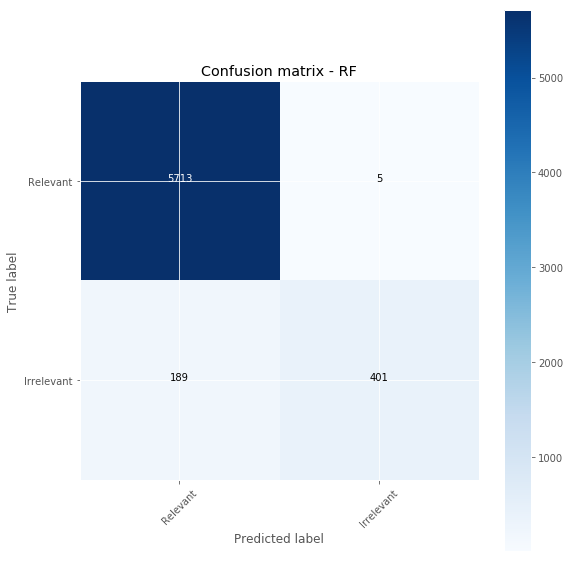

Accuracy on train: 0.97


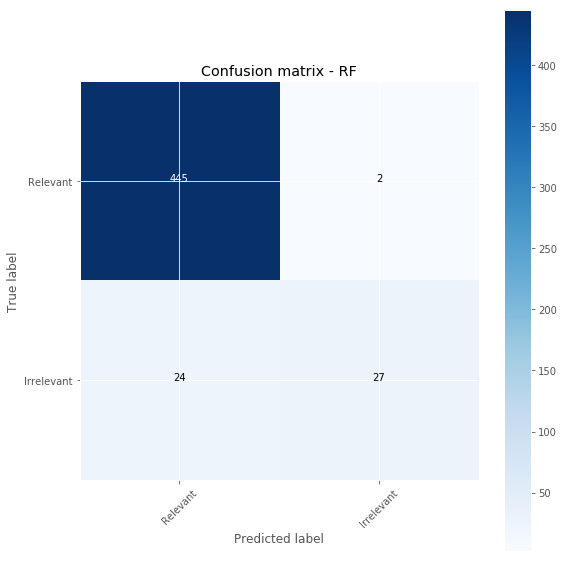

Accuracy on test: 0.95


In [30]:
labels = {'support': {'names': ['Anti-Israel', 'Neutral', 'Pro-Israel'], 'values': [-1,0,1]},
          'relevance': {'names': ['Relevant', 'Irrelevant'], 'values': [0,1]}}

ml_model.plot_confusion_matrix(list(predictions_train.prediction), list(predictions_train.true_value), 'RF', 'train', labels[config['target']])
ml_model.plot_confusion_matrix(list(predictions_test.prediction), list(predictions_test.true_value), 'RF', 'test', labels[config['target']])
#ml_model.plot_confusion_matrix(list(predictions_external_test.prediction), list(predictions_external_test.true_value), 'RF', 'external_test', labels[config['target']])

# calculate accuracy
accuracy_train = metrics.accuracy_score(list(predictions_train.true_value), list(predictions_train.prediction), normalize=True)
accuracy = metrics.accuracy_score(list(predictions_test.true_value), list(predictions_test.prediction), normalize=True)
# accuracy = metrics.accuracy_score(list(predictions_external_test.true_value), list(predictions_external_test.prediction), normalize=True)

In [31]:
with open('{}_features_list.pickle'.format(config['target']), 'rb') as handle:
    features = pickle.load(handle)
print('Final number of features: {}'.format(len(features)))
print('Feature list:\n')
print(sorted(features))

Final number of features: 141
Feature list:

['has_RT', 'has_anti_org', 'has_hostile_countries', 'has_image', 'has_israeli_politician', 'has_link', 'has_news_company', 'has_pro_org', 'has_terror_orgs', 'has_us_politician', 'has_video_ref', 'hash_#abc', 'hash_#apartheid', 'hash_#bds', 'hash_#earthquake', 'hash_#economy', 'hash_#freegaza', 'hash_#gaza', 'hash_#gazaunderattack', 'hash_#health', 'hash_#icc4israel', 'hash_#iran', 'hash_#islam', 'hash_#israel', 'hash_#israeli', 'hash_#jerusalem', 'hash_#land', 'hash_#lovely', 'hash_#nbc', 'hash_#netanyahu', 'hash_#news', 'hash_#nufc', 'hash_#obama', 'hash_#palestine', 'hash_#palestinians', 'hash_#politics', 'hash_#sjp', 'hash_#un', 'hash_#us', 'hash_#zionism', 'hostile_entities', 'num_capital_letters', 'num_capital_words', 'num_domain_keywords', 'num_hashtags', 'num_mentions', 'num_negation_words', 'num_slang_words', 'num_tokens', 'num_words_len_1', 'positive_entities', 'subjectivity', 'text_length_vs_tokens_ratio', 'total_important_hashtags